In [1]:
import pandas as pd
import numpy as np
from pymatgen.io.vasp import Outcar
from functions import get_mean_std_from_model, contcar_to_graph
from torch_geometric.loader import DataLoader
from graph_tools import extract_adsorbate
import cycler
import torch
import matplotlib.pyplot as plt
from nets import SantyxNet
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
legend_font = FontProperties(family='Arial', style='normal', size=9)
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import r2_score
import os

# Load GNN pre-trained model 
MODEL_NAME = "best_hypopt_test2"
MODEL_PATH = "./Models/{}/".format(MODEL_NAME)    
model = torch.load("{}/model.pth".format(MODEL_PATH))
model.load_state_dict(torch.load("{}GNN.pth".format(MODEL_PATH)))
model.eval()
model.to("cpu")

# Create a folder for the specific GNN model tested on the BM_dataset
os.mkdir("./Performance_BMdataset/{}".format(MODEL_NAME))

# Get mean and std for re-scaling the GNN output in production phase 
mean_tv, std_tv = get_mean_std_from_model(MODEL_PATH)

# Function for counting non-H atoms in adsorbates
atom_counter = lambda graph: graph.x.sum(axis=0)[[2, 7, 9, 15]].sum().item()

# Raed csv with adsorption energy of the BM dataset
df = pd.read_csv("./BM_dataset/DFT_BM.csv")
Eads_DFT = df["Eads / eV"]
Eads_GNN = np.zeros((35,1))
df["gnn"] = 0
df.index = df["System"]
df = df.drop(columns=["System", "Etot / eV", "Esur / eV", "Emol / eV"])
df.columns = ["Family", "Eads_DFT", "Eads_GNN"]
df["Family"] = [df["Family"][i].capitalize() for i in range(len(df["Family"]))]

In [2]:
from functions import test_loop
from processed_datasets import BM_dataloader

test_loop(model, BM_dataloader, "cuda", std_tv, mean_tv, False, verbose=1)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

# Biomass

In [3]:
ni_energy = Outcar("./BM_dataset/Biomass/ni-0000/OUTCAR").final_energy
ru_energy = Outcar("./BM_dataset/Biomass/ru-0000/OUTCAR").final_energy
BIOMASS = ["mol1", "mol2", "mol3", "mol4", "mol5"]
METAL_BIOMASS = ["ni", "ru"]
sur_energy = {"ni": ni_energy, "ru": ru_energy}
Eads_GNN_biomass = []
E_mol_biomass = []
labels = []
ADSOSRBATES_ATOMS_BIOMASS = []
counter = 0
for metal in METAL_BIOMASS:
    for molecule in BIOMASS:
        calc = "{}-{}".format(metal, molecule)
        labels.append(calc.capitalize())
        system = "./BM_dataset/Biomass/{}/CONTCAR".format(calc)
        data = contcar_to_graph(system)
        ADSOSRBATES_ATOMS_BIOMASS.append(atom_counter(data))
        adsorbate = extract_adsorbate(data)
        if data.num_nodes == adsorbate.num_nodes:
            print("{}-{}: Wrong graph representation".format(metal, molecule))
        loader = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in loader:
            Eads_GNN_biomass.append(model(batch).item() * std_tv + mean_tv)
        counter += 1
for molecule in BIOMASS:
    calc = "{}".format(molecule)
    system = "./BM_dataset/Biomass/{}/CONTCAR".format(calc)
    data = contcar_to_graph(system)
    loader = DataLoader([data], batch_size=1, shuffle=False)   
    for batch in loader:
        E_mol_biomass.append(model(batch).item() * std_tv + mean_tv)
    counter += 1
E_mol_biomass = E_mol_biomass * 2
for i in range(len(Eads_GNN_biomass)):
    Eads_GNN_biomass[i] -= E_mol_biomass[i]
    Eads_GNN[20+i:] = Eads_GNN_biomass[i]
    
Eads_biomass_dict = dict(zip(labels, Eads_GNN_biomass))
Eads_biomass_dict
for label in list(Eads_biomass_dict.keys()):
    df["Eads_GNN"][label] = Eads_biomass_dict[label]


/tmp/ipykernel_6710/4045320281.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Eads_GNN"][label] = Eads_biomass_dict[label]


# Polyurethanes

In [4]:
ag_energy = Outcar("./BM_dataset/Polyurethanes/ag-sur/OUTCAR").final_energy
cu_energy = Outcar("./BM_dataset/Polyurethanes/cu-sur/OUTCAR").final_energy
au_energy = Outcar("./BM_dataset/Polyurethanes/au-sur/OUTCAR").final_energy * 4
POLYURETHANES = ["mol16", "mol17", "mol18", "mol19", "mol41"]
METAL_POLYURETHANES = ["ag", "au", "cu"]
sur_energy = {"ag": ag_energy, "cu": cu_energy, "au": au_energy}
Eads_GNN_polyurethanes = []
E_mol_polyurethanes = []
ADSOSRBATES_ATOMS_POLYURETHANES = []
labels = []
counter = 0
for metal in METAL_POLYURETHANES:
    for molecule in POLYURETHANES:
        calc = "{}-{}".format(metal, molecule)
        labels.append(calc.capitalize())
        system = "./BM_dataset/Polyurethanes/{}/CONTCAR".format(calc)
        data = contcar_to_graph(system)
        ADSOSRBATES_ATOMS_POLYURETHANES.append(atom_counter(data))
        adsorbate = extract_adsorbate(data)
        if data.num_nodes == adsorbate.num_nodes:
            print("{}-{}: Wrong graph representation".format(metal, molecule))
        loader = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in loader:
            Eads_GNN_polyurethanes.append(model(batch).item() * std_tv + mean_tv)
        counter += 1
for molecule in POLYURETHANES:  # gas phase molecules
    calc = "{}".format(molecule)
    system = "./BM_dataset/Polyurethanes/{}/CONTCAR".format(calc)
    data = contcar_to_graph(system)
    loader = DataLoader([data], batch_size=1, shuffle=False)   
    for batch in loader:
        E_mol_polyurethanes.append(model(batch).item() * std_tv + mean_tv)
    counter += 1
E_mol_polyurethanes = E_mol_polyurethanes * 3
for i in range(len(Eads_GNN_polyurethanes)):
    Eads_GNN_polyurethanes[i] -= E_mol_polyurethanes[i]
    Eads_GNN[i] = Eads_GNN_polyurethanes[i]
    
Eads_polyurethanes_dict = dict(zip(labels, Eads_GNN_polyurethanes))
Eads_polyurethanes_dict

for label in list(Eads_polyurethanes_dict.keys()):
    df["Eads_GNN"][label] = Eads_polyurethanes_dict[label]

ag-mol16: Wrong graph representation
au-mol18: Wrong graph representation
au-mol19: Wrong graph representation
cu-mol17: Wrong graph representation
cu-mol18: Wrong graph representation
cu-mol19: Wrong graph representation
cu-mol41: Wrong graph representation


# Plastics

In [5]:
pt_energy = Outcar("./BM_dataset/Plastics/pt-0000/OUTCAR").final_energy * 4
ru_energy = Outcar("./BM_dataset/Plastics/ru-0000/OUTCAR").final_energy * 4
PLASTICS = ["PE", "PPit", "PPst", "PS", "PET"]
METAL_PLASTICS = ["pt", "ru"]
sur_energy = {"pt": pt_energy, "ru": ru_energy}
Eads_GNN_plastics = []
E_mol_plastics = []
ADSOSRBATES_ATOMS_PLASTICS = []
labels = []
counter = 0
for metal in METAL_PLASTICS:
    for molecule in PLASTICS:
        calc = "{}-{}".format(metal, molecule)
        labels.append(calc[0].upper() + calc[1:])
        system = "./BM_dataset/Plastics/{}/CONTCAR".format(calc)
        data = contcar_to_graph(system)
        ADSOSRBATES_ATOMS_PLASTICS.append(atom_counter(data))
        adsorbate = extract_adsorbate(data)
        if data.num_nodes == adsorbate.num_nodes:
            print("{}-{}: Wrong graph representation".format(metal, molecule))
        loader = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in loader:
            Eads_GNN_plastics.append(model(batch).item() * std_tv + mean_tv)
        counter += 1
for molecule in PLASTICS:  # gas phase molecules
    calc = "{}".format(molecule)
    system = "./BM_dataset/Plastics/{}/CONTCAR".format(calc)
    try:
        data = contcar_to_graph(system)
        loader = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in loader:
            E_mol_plastics.append(model(batch).item() * std_tv + mean_tv)
        counter += 1
    except:
        E_mol_plastics.append(0)
        counter += 1
E_mol_plastics = E_mol_plastics * 2
for i in range(len(Eads_GNN_plastics)):
    Eads_GNN_plastics[i] -= E_mol_plastics[i]
    Eads_GNN[10+i] = Eads_GNN_plastics[i]
    
Eads_plastics_dict = dict(zip(labels, Eads_GNN_plastics))
Eads_plastics_dict

for label in list(Eads_plastics_dict.keys()):
    df["Eads_GNN"][label] = Eads_plastics_dict[label]

pt-PPst: Wrong graph representation
ru-PE: Wrong graph representation
ru-PPst: Wrong graph representation


/tmp/ipykernel_6710/2149782312.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Eads_GNN"][label] = Eads_plastics_dict[label]
/tmp/ipykernel_6710/2149782312.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Eads_GNN"][label] = Eads_plastics_dict[label]
/tmp/ipykernel_6710/2149782312.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Eads_GNN"][label] = Eads_plastics_dict[label]
/tmp/ipykernel_6710/2149782312.py:46:

In [6]:
ADS_ATOMS = []
for i in range(5):
    ADS_ATOMS.append(ADSOSRBATES_ATOMS_POLYURETHANES[i])
for i in range(5):
    ADS_ATOMS.append(ADSOSRBATES_ATOMS_POLYURETHANES[i+10])
for i in range(10):
    ADS_ATOMS.append(ADSOSRBATES_ATOMS_PLASTICS[i])
for i in range(10):
    ADS_ATOMS.append(ADSOSRBATES_ATOMS_BIOMASS[i])
for i in range(5):
    ADS_ATOMS.append(ADSOSRBATES_ATOMS_POLYURETHANES[i+5])

In [7]:
df["Error"] = df["Eads_DFT"] - df["Eads_GNN"]
df["Absolute Error"] = abs(df["Error"])
df["Metal"] = [df.index[i][:2] for i in range(len(df.index))]
df["Adsorbate atoms"] = ADS_ATOMS
df["Err per atom"] = df["Absolute Error"] / df["Adsorbate atoms"]
MAE_atom = np.mean(np.abs(df["Err per atom"]))
s_atom = np.std(np.abs(df["Err per atom"]))
MAE = np.mean(np.abs(df["Error"]))
s_E = np.std(df["Error"])
R2_BM = r2_score(df["Eads_DFT"], df["Eads_GNN"])
print("R2 (entire BM-dataset) = {}".format(R2_BM))
df.to_csv("./Performance_BMdataset/{}/Table_BM_dataset_{}.csv".format(MODEL_NAME, MODEL_NAME))

R2 (entire BM-dataset) = 0.3595425940703817


In [8]:
df= df[df["Metal"].str.contains("Cu") == False]
R2 = r2_score(df["Eads_DFT"], df["Eads_GNN"])
print("R2 (removed Cu) = {}".format(R2))

R2 (removed Cu) = 0.48694995644416805


## Create parity plot DFT vs GNN

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


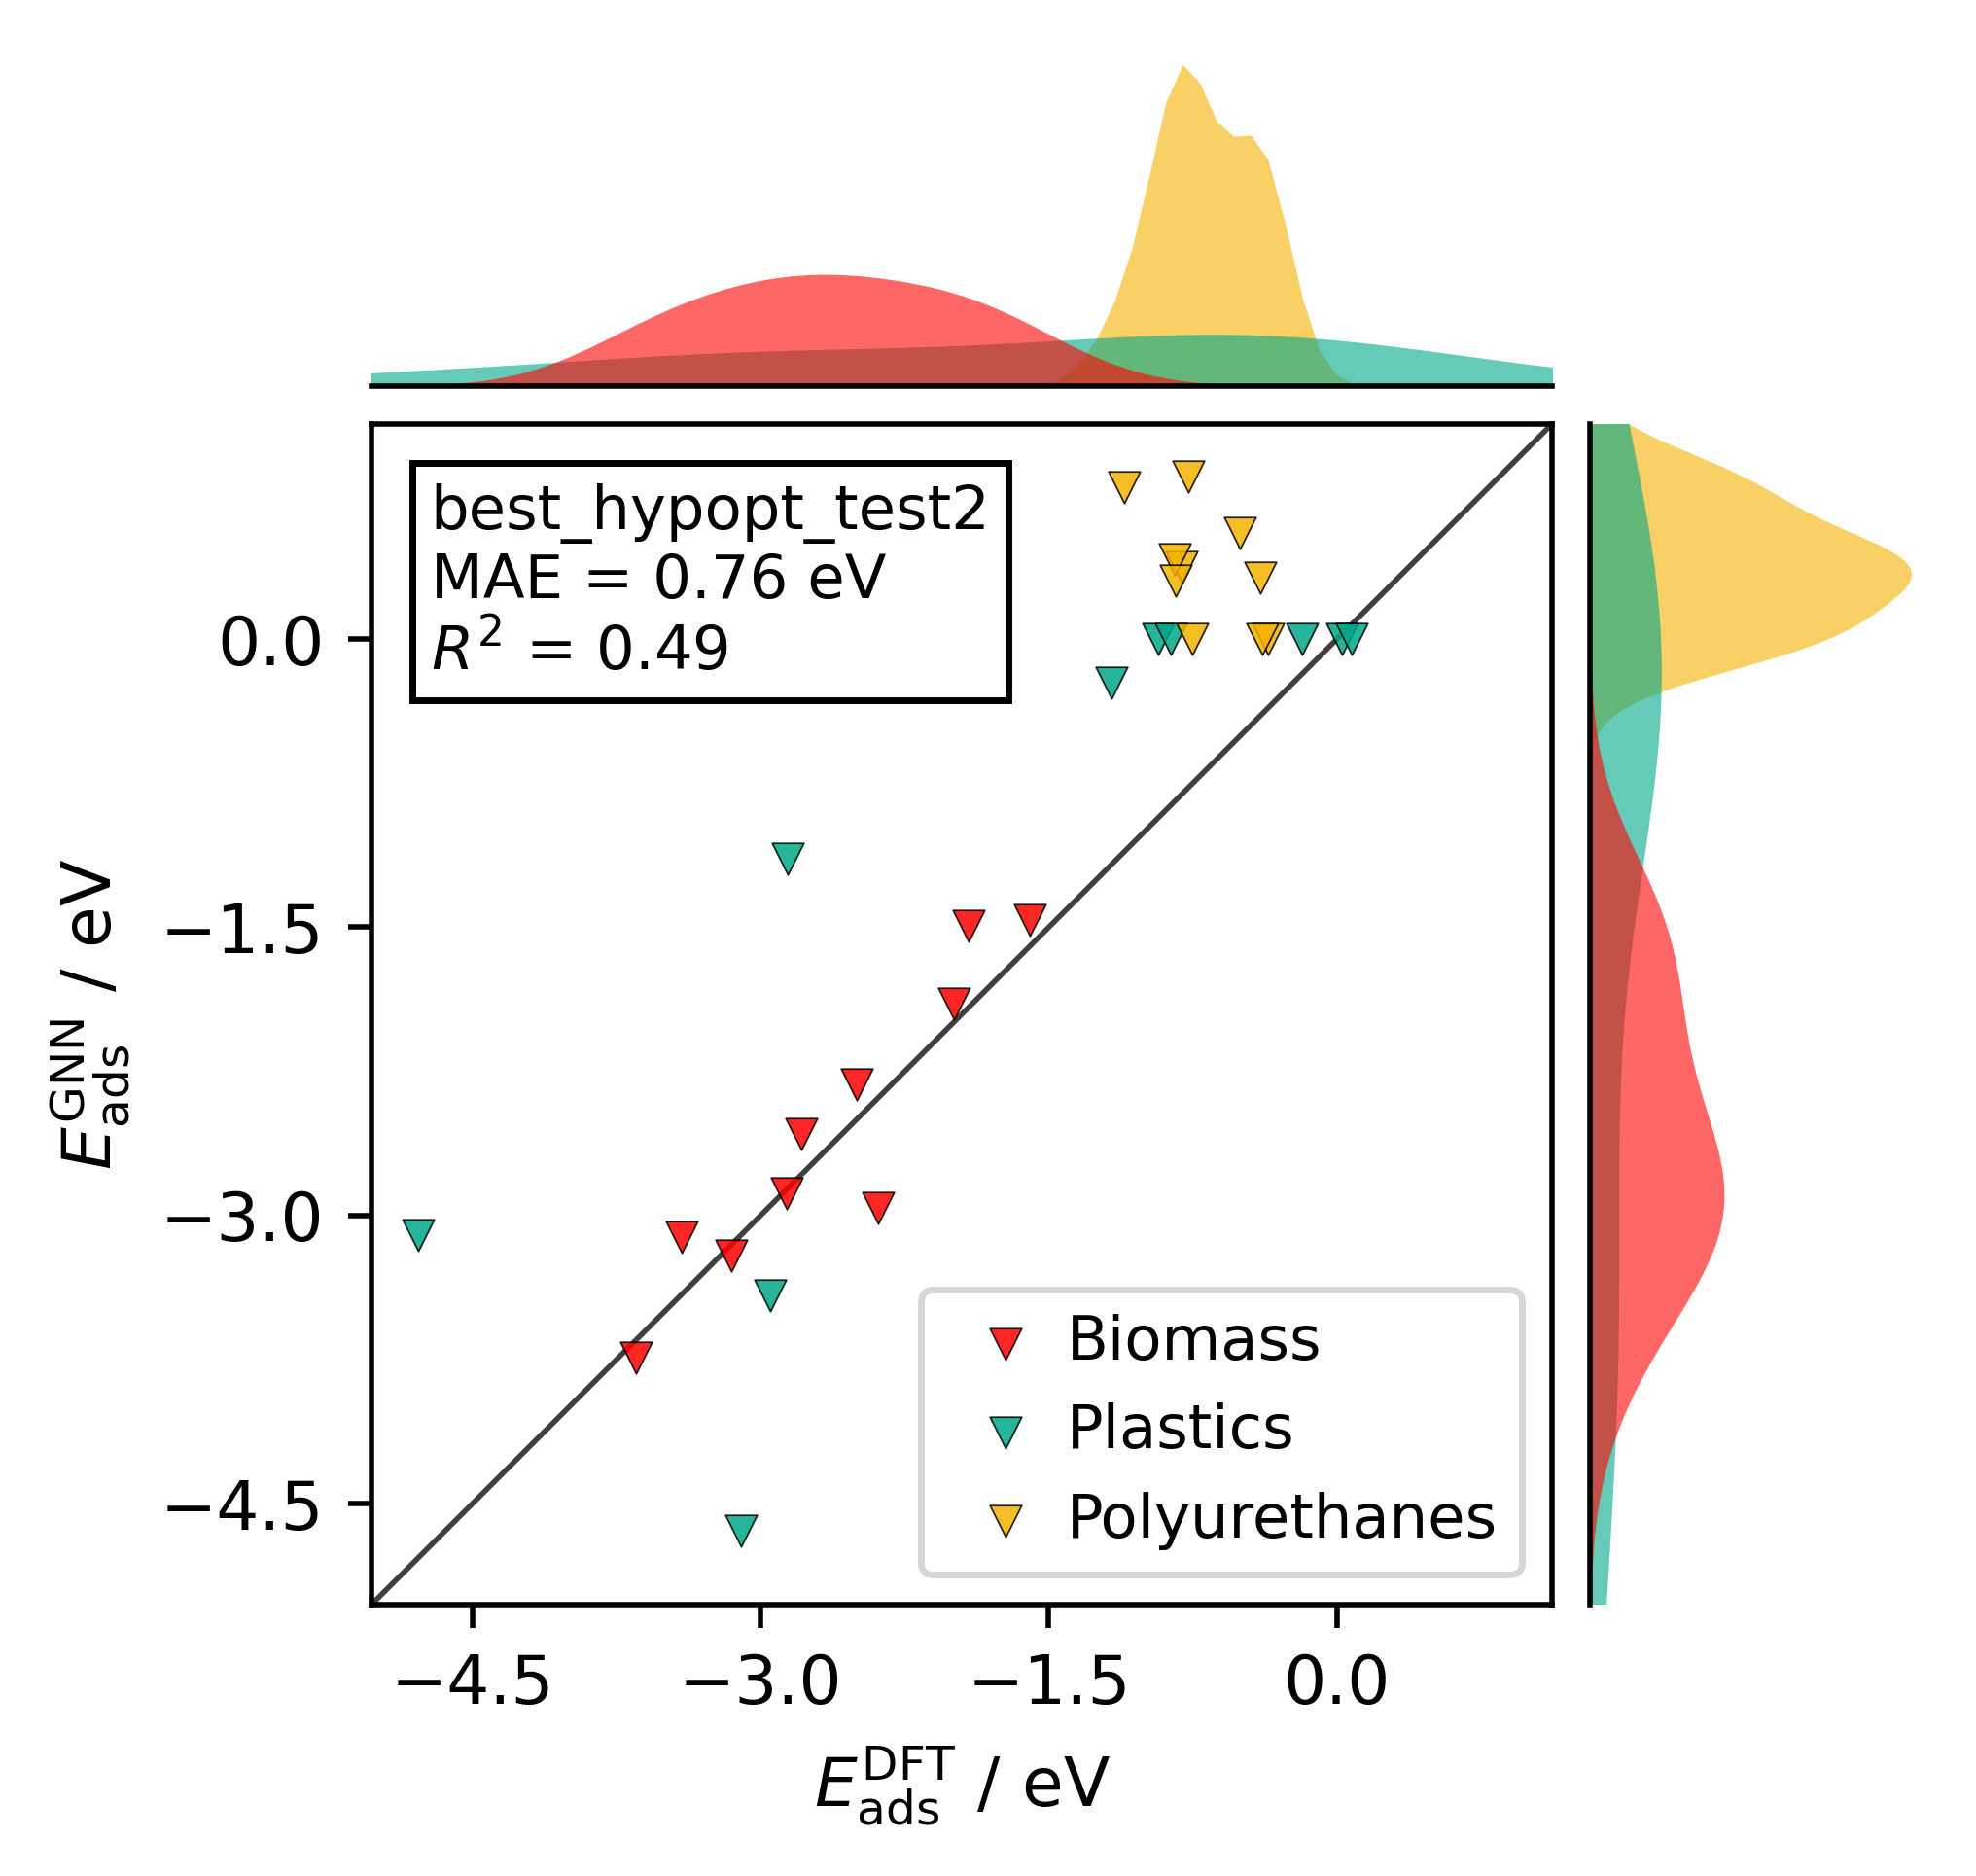

In [9]:
fig = plt.figure(figsize=(4,4), dpi=500)
params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
gs = GridSpec(4, 4)
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatterplot
# ax_scatter.set_ylabel('GNN Prediction / eV')
# ax_scatter.set_xlabel('DFT Value / eV')
ax_scatter.set_ylabel('$\mathit{E}_{ads}^{GNN}$ / eV')
ax_scatter.set_xlabel('$\mathit{E}_{ads}^{DFT}$ / eV')
PALETTE = ["#FF0000", "#00A789", "#F4B200"]
PALETTE_SERGIO = ["#FA8419", "#9D65FF", "#F4005F"]
PALETTE_HET = ["#F2071B", "#0487D9", "#038C3E"]
ax_scatter.set_prop_cycle(cycler.cycler(color=PALETTE))
for label, series in df.groupby("Family"):
        ax_scatter.scatter(series["Eads_DFT"], series["Eads_GNN"],
                   s=22, marker="v", alpha=0.85, edgecolors="black", linewidths=0.25, zorder=2, label=label)
# for idx, data in df.iterrows():
#      ax_scatter.annotate(data["Metal"], (data["Eads_DFT"]+0.1, data["Eads_GNN"]+0.1), fontsize=5)
ax_scatter.yaxis.set_major_locator(MaxNLocator(5)) 
ax_scatter.xaxis.set_major_locator(MaxNLocator(5)) 
legend_font = FontProperties(family='Arial', style='normal', size=9)
ax_scatter.legend(loc="lower right", prop=legend_font, handletextpad=0)
#lims = [-5.2, 0.2]  # max of both axes
lims = [np.min([ax_scatter.get_xlim(), ax_scatter.get_ylim()]),  # min of both axes
         np.max([ax_scatter.get_xlim(), ax_scatter.get_ylim()])]  # max of both axes
ax_scatter.plot(lims, lims, 'k-', alpha=0.75, zorder=1, linewidth=0.8)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)
ax_scatter.set_axisbelow("True")
#ax_scatter.grid()
#text = "MAE = {:.2f} eV\n  SE = {:.2f} eV\nModel = {}".format(MAE, s_E/np.sqrt(30), MODEL_NAME)
text = "{}\nMAE = {:.2f} eV\n$\mathit{{R}}^{{2}}$ = {:.2f}".format(MODEL_NAME, MAE, R2)
props = dict(boxstyle='square', facecolor='white')
ax_scatter.text(0.05, 0.95, text, transform=ax_scatter.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# histogram GNN
ax_hist_y.tick_params(axis="y", labelleft=False, left=False)
ax_hist_y.tick_params(axis="x", labelbottom=False, bottom=False)
sns.kdeplot(data=df,
            y='Eads_GNN',
            hue='Family',
            hue_order=['Biomass', 'Plastics', 'Polyurethanes'],
            ax=ax_hist_y,
            legend=False, 
            palette=PALETTE, 
            fill=True, 
            multiple="layer", 
            alpha=0.6, 
            linewidth=0, 
            common_norm=False, 
            common_grid=False, 
            gridsize=100)
ax_hist_y.spines.right.set_visible(False)
ax_hist_y.spines.top.set_visible(False)
ax_hist_y.spines.bottom.set_visible(False)
# histogram DFT 
ax_hist_x.tick_params(axis="x", labelbottom=False, bottom=False)
ax_hist_x.tick_params(axis="y", labelleft=False, left=False)
sns.kdeplot(data=df,
            x='Eads_DFT',
            hue='Family',
            hue_order=['Biomass', 'Plastics', 'Polyurethanes'],
            ax=ax_hist_x,
            legend=False, 
            palette=PALETTE, 
            fill=True, 
            multiple="layer", 
            alpha=0.6, 
            linewidth=0, 
            common_norm=False, 
            common_grid=True, 
            gridsize=100)
ax_hist_x.spines.right.set_visible(False)
ax_hist_x.spines.top.set_visible(False)
ax_hist_x.spines.left.set_visible(False)
plt.savefig("./Performance_BMdataset/{}/parity_plot_{}.svg".format(MODEL_NAME, MODEL_NAME), bbox_inches='tight')
plt.savefig("./Performance_BMdataset/{}/parity_plot_{}.png".format(MODEL_NAME, MODEL_NAME), bbox_inches='tight')
